This code is for plotting using the full model domain rather than slong specific inline or crossline sections. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
from scipy.stats import variation
from xml.dom import minidom


from scipy import interpolate
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


plt.style.use('seaborn-pastel')


#plt.rcParams['animation.ffmpeg_path'] = '/opt/local/bin/ffmpeg'
%matplotlib inline
#%matplotlib qt

Make new cmap from StratBuilder Code

In [2]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [43]:
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
# test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','0e87cc', '2242c77', '0504aa','0504aa', '00035b'] 
test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa','0504aa', '00035b', '020035'] 

#test = ['96e821','90992b', 'dc983d', 'efb763', '0e87cc','062029']#,'062029']#,'062029','062029']#,'069af3', '0e87cc', '2242c77', '0504aa', '00035b'] from satellite images
#test = ['062029', '062029', '0e87cc', 'efb763', 'dc983d', '90992b', '96e821']
centrelines = ['ffffff', '000000']


 ## source of this function: http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html#code
def make_cmap(colors, position=None, bit=False):

    if len(position) != len(colors):
        sys.exit('position length must be the same as colors')
    elif position[0] != 0 or position[-1] != 1:
        sys.exit('position must start with 0 and end with 1')
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):

        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

        cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    return cmap

## load source xml file
xmldoc = minidom.parse('/Users/safiya/Documents/Python/colourmaps/turqoise-olive.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

mycmap = make_cmap(color_vals,data_vals)
print('converted successfully!')

#mycmap_r = ListedColormap(mycmap.colors[::-1])

# mycmap is matplotlib compatible object. to query color value out of it:

print('example rgba value for data value 0 is: ' + str(mycmap(0.0)))

In [4]:
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m
iloc = 300 #location of the section along i axis
jloc = 14#location of the secion along j axis
thot_SS = 820800 #
#time from which we restarted the runs to add a flood
fldstart_s = 3600 ##start time of flood in seconds
fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

In [5]:
datnam = f'{idf}-datamaster-{intstring}.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s
cellW = 4
cellL = 10
xloc = iloc*cellW
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

In [6]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)
#mpl.rc('axes',  edgecolor='w')


In [7]:
print(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

#savefilesto = '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Plots/'
modelrun = f'{nickname}-hr-{fldlength}hrfld-{iloc}'

##define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5
uprbd = 0
lwrbd= 1000
print('Shape of the datamaster dataset is: ', datamaster.shape)
savefilesto = (f'/Volumes/SAF_Data/NAYS2DH_files/Plots/videos/vid-{lwrbd}-{idf}-{nickname}')

/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour.npy
Shape of the datamaster dataset is:  (26026, 11, 382)


In [8]:
print(savefilesto)

/Volumes/SAF_Data/NAYS2DH_files/Plots/videos/vid-1000-0hfld-agubh2-10km


In [9]:
num_timesteps = datamaster.shape[2] ## or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ##when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ##flood starttime, s

print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382
Shape of data used to plot: (26026, 11, 382)


## Set up the meshgrid to plot the surface

Just a check to set the colorbar 

func = interpolate.interp2d(xdomain, ydomain, elev, kind = 'cubic')
newelev = 

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


attribute top: 0.81. Midpoint: 0.42
0.0 8.27077947563


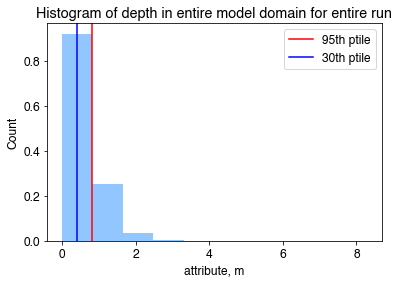

In [44]:
#create 2D grid
#extract elevation

char = 10 ## what do you want to colour by? flow depth (4), elevation change (7), velocity (10) etc
attribs = datamaster[:, char, :].ravel() # scaling to find your normalisation for the attribute/char you choose to colour with
avattribs = np.average(attribs)
locd = np.average(avattribs)
scd = np.std(avattribs)
attx = np.linspace(attribs.min(), attribs.max())
apdf = stats.norm.pdf(attx, locd, scd)
plt.hist(attribs, density=True);

toplim = np.quantile(attribs, 0.75) ##was initally .45 and .65 of velocity
lowlim = np.quantile(attribs, 0.45)
plt.axvline(toplim, c = 'r', label = '95th ptile')
plt.axvline(lowlim, c = 'b', label = '30th ptile')
plt.xlabel('attribute, m')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of depth in entire model domain for entire run');
print(f'attribute top: {np.round(toplim, 2)}. Midpoint: {np.round(lowlim, 2)}')
post_idx = -1

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
#elev_final = np.reshape(datamaster[:, char, -1], (gridy, gridx)) ##using flow depth to plot
#elev_pref = np.reshape(datamaster[:, char, pref_idx], (gridy, gridx)) ##using flow depth to plot
elev_postf = np.reshape(datamaster[:, char, post_idx], (gridy, gridx)) ##using flow depth to plot

llim = datamaster[:, 3, :].min()
ulim = datamaster[:, 3, :].max()

#find the max and min of the variable you're plotting to scale the colourmap
var_llim = datamaster[:, char, :].min() 
var_ulim = datamaster[:, char, :].max()
print(var_llim, var_ulim)


# Make a user-defined colormap.
#cm1 = plt.get_cmap('viridis')
#cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))

# Turn these into an object that can be used to map time values to colors and can be passed to plt.colorbar().
#cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1) 
#cpick.set_array([])

# modified hsv in 256 color class
ge_modified = cm.get_cmap('gist_earth', 256)
# create new hsv colormaps in range of 0.3 (green) to 0.7 (blue)
newcmp = ListedColormap(ge_modified(np.linspace(0, 0.5, 256)))


# define top and bottom colormaps 
top = cm.get_cmap('Oranges', 128) # r means reversed version
bottom = cm.get_cmap('Blues_r', 128)# combine it all
newcolors = np.vstack((bottom(np.linspace(0, 1, 128)),
                       top(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

In [45]:
class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#normalise = plt.Normalize(-1, 2)
#midnorm = MidpointNormalize(vmin=-np.quantile(datamaster[:, 4, :], 0.1), vcenter=0.5, vmax=np.quantile(datamaster[:, 4, :], 0.99))
#midnorm = MidpointNormalize(vmin=0, vcenter=np.quantile(datamaster[:, char, :], .25), vmax=np.quantile(datamaster[:, char, :], .999)) 
#midnorm = MidpointNormalize(vmin=0, vcenter=lowlim, vmax=toplim) 
#midnorm = MidpointNormalize(vmin = np.quantile(datamaster[:, 7, :], 0.01), vcenter = 0, vmax = np.quantile(datamaster[:, 7, :], 0.99))
midnorm = MidpointNormalize(vmin = 0, vcenter = lowlim, vmax = toplim)
# midnorm = MidpointNormalize(vmin = 0, vcenter = 0.3, vmax = 2)

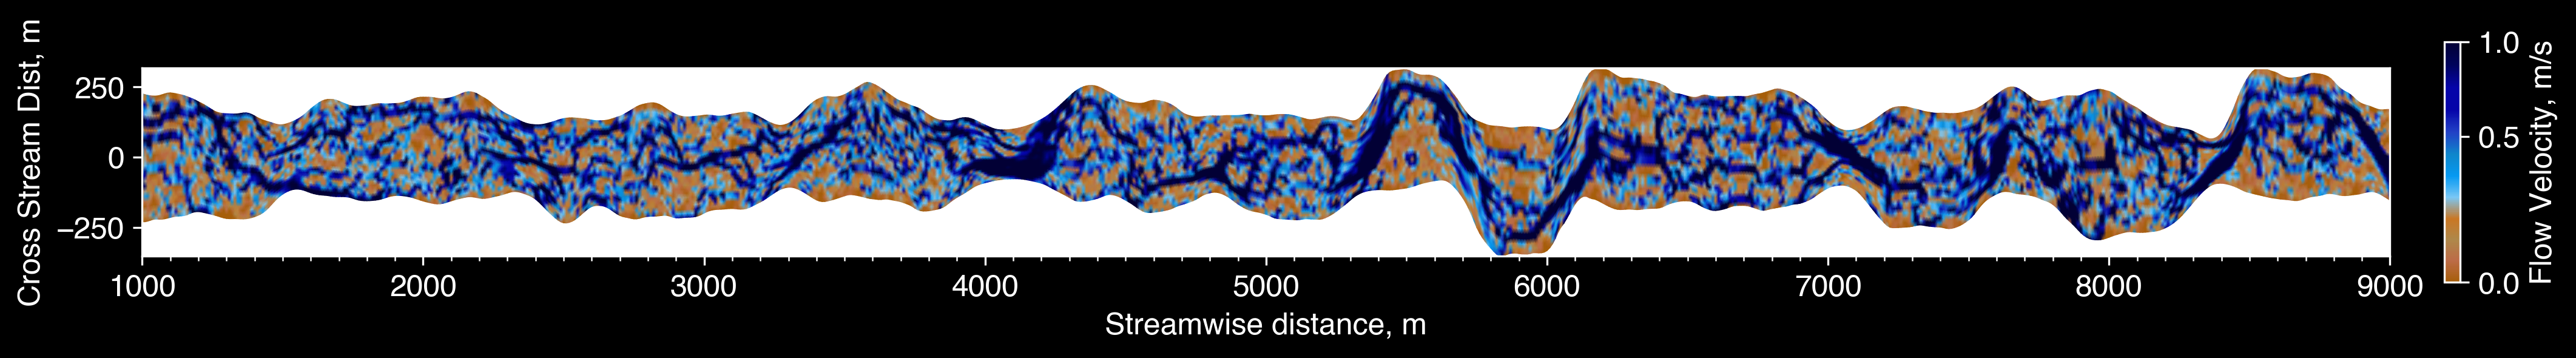

In [48]:
with plt.style.context('dark_background'):
    #z = np.reshape(datamaster[:, 4, 4], (-1, 2))
    fig, ax = plt.subplots(figsize=(19.2, 5), tight_layout = False, dpi = 300)
    #x = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'hsv')#, norm = normalise)
    x = ax.pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud')
    ax.set_xlim(1000, 9000)
    #ax.set_ylim(-200, 200)
    ax.set_aspect('equal')
    ax.set_facecolor('w')
    fig.colorbar(x, ax=ax, label = "Flow Velocity, m/s", shrink=0.35, pad = 0.02, aspect=15)
    ax.set_xlabel('Streamwise distance, m', color = 'white')
    ax.set_ylabel('Cross Stream Dist, m', color = 'white')
    #ax.set_facecolor('xkcd:green brown')
ax.xaxis.set_minor_locator(MultipleLocator(100))
#plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0);  plt.margins(0, 0)

# plt.savefig('/Volumes/SAF_Data/figs/planformfig_final.png')

data = np.reshape(datamaster[:, 8, 20], (gridy, gridx))
print(data)
#fig, axs = plt.subplots(1, 5, sharex = True, sharey = True, figsize = (15, 5))
#axs[0].set_xlim(0, 100)
plt.contourf(xdomain, ydomain, data)

## Full Model Domain

In [18]:
print(llim, ulim)

-368.130758117 317.435934729


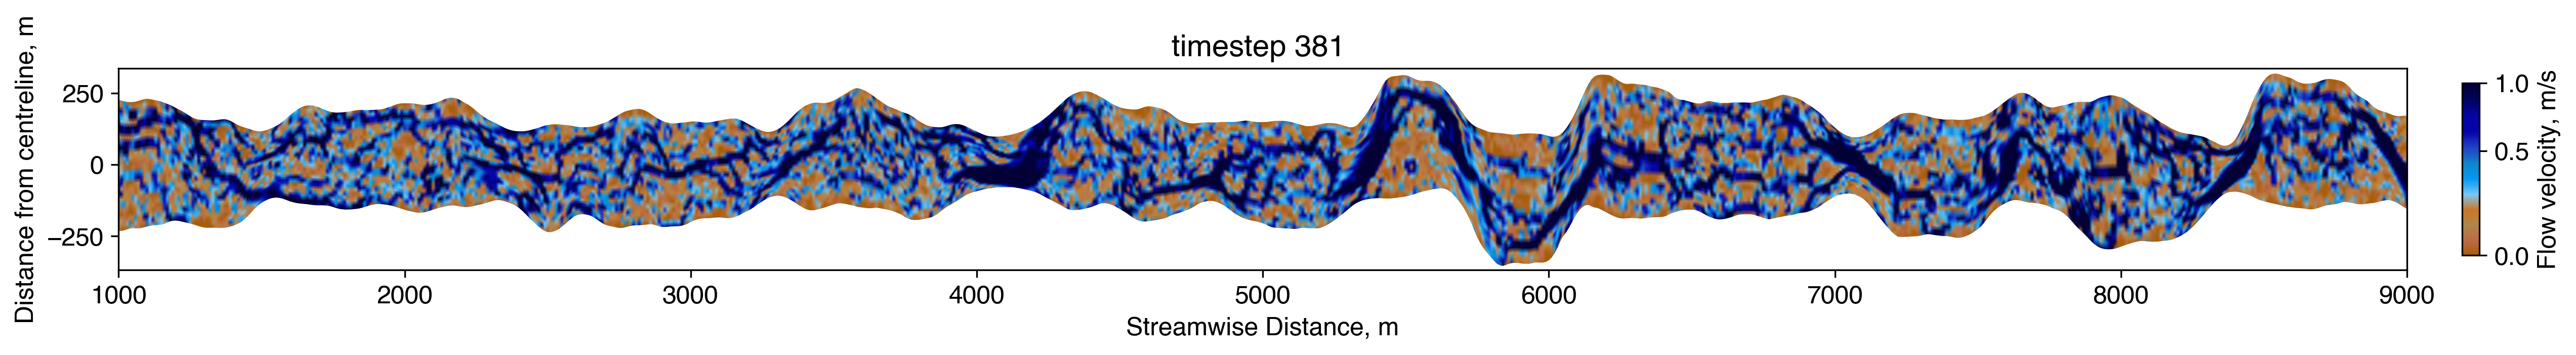

In [51]:
#matplotlib.rc('axes',edgecolor='r')
# with plt.style.context('dark_background'):
fig, ax = plt.subplots(figsize = (19.20, 3.60), tight_layout = True, dpi = 300)
data = ax.pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud')#, norm = midnorm, shading = 'gouraud')
ax.set_aspect('equal')
uprbd = 1000
lwrbd = 9000
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[ :, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, char, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth', norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud')
    ax.set_ylim(llim, ulim)
    ax.set_xlim(uprbd, lwrbd)
    ax.set_title(f'timestep {(i)} ') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_aspect('equal')
    ax.set_ylabel('Distance from centreline, m')
    ax.set_facecolor('w')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0);  plt.margins(0, 0)

fig.colorbar(data, ax=ax, label = 'Flow velocity, m/s', shrink = 0.35, pad=0.02, aspect = 10)
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
savefilesto = (f'/Volumes/SAF_Data/NAYS2DH_files/Plots/videos/w-vid-full-{idf}-{nickname}')
filesave = str(savefilesto)+'.mp4'
ani.save(filesave, writer = writer)

#plt.close()

In [27]:
print(num_timesteps)

310


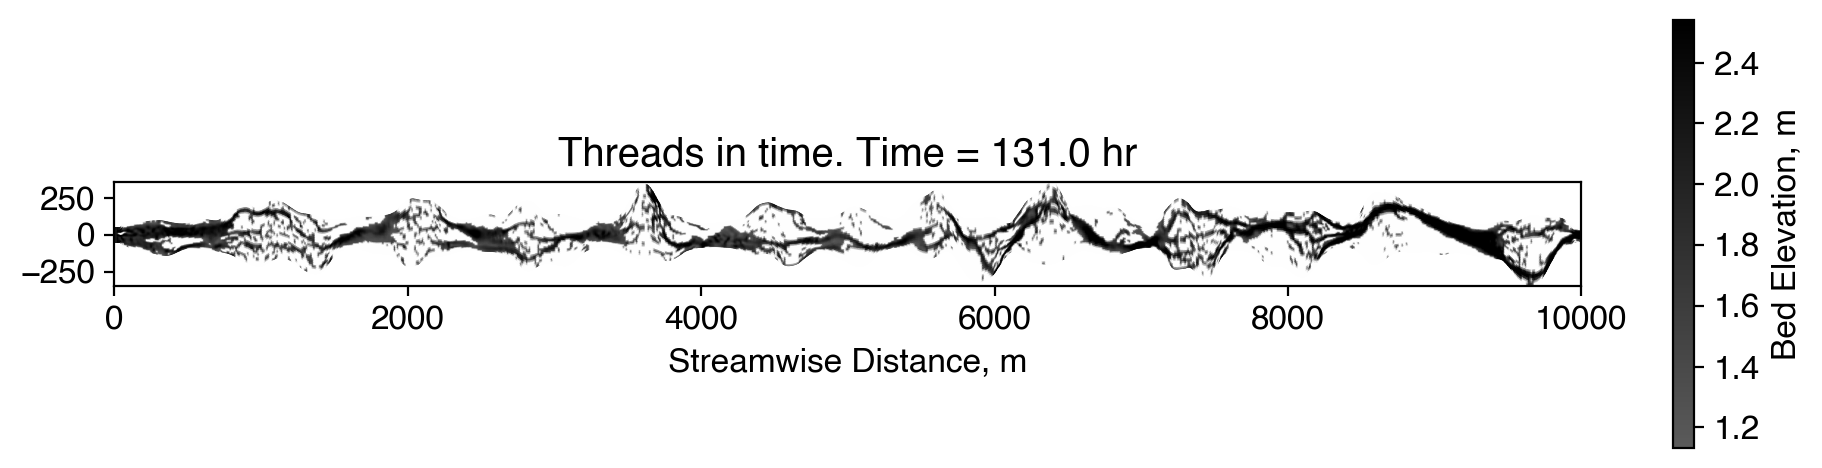

In [30]:
climu = np.quantile(attribs, 0.99) #upper centreline limit
climl = np.quantile(attribs, 0.75) #lower limits
climc = np.quantile(attribs, 0.45) #lower limits
cnorm = MidpointNormalize(vmin=climl, vcenter=climc, vmax=climu) 

fig, ax = plt.subplots(figsize = (10, 2.5), tight_layout = True, dpi = 200)
data = ax.pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(centrelines), norm = cnorm, shading = 'gouraud')#, norm = midnorm, shading = 'gouraud')
ax.set_aspect('equal')
uprbd = 0
lwrbd = 10000
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[ :, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, char, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth', norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = get_continuous_cmap(centrelines), norm = cnorm, shading = 'gouraud')
    ax.set_ylim(llim, ulim)
    ax.set_xlim(uprbd, lwrbd)
    ax.set_title(f'Threads in time. Time = {i*interval_to_plot} hr') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_aspect('equal')
    #ax.set_ylabel('Cross Stream Distance, m')
#ax.set_facecolor('xkcd:green brown')
fig.colorbar(data, ax=ax, label = 'Bed Elevation, m')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
savefilesto = (f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Plots/videos/vid-threads-{idf}-{nickname}')
filesave = str(savefilesto)+'.mp4'
ani.save(filesave, writer = writer)

#plt.show()


In [31]:
print(f'{savefilesto}.mp4')

/Volumes/SAF_MSCWORK/Python/Stratigraphy/Plots/videos/vid-threads-HHDV-agubh2-10km.mp4


fig, ax = plt.subplots(figsize = (15, 5), tight_layout = True, dpi = 1000)
data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap)#, norm = midnorm, shading = 'gouraud')
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[:, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, 8, i], (gridy, gridx))
    
    
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = mycmap, norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap, norm = midnorm, shading = 'gouraud')
    ax.clear()
    ax.set_ylim(llim, ulim)
    ax.set_xlim(0, 5000)
    ax.set_title('Time = '+ str(round(i*interval_to_plot))+ ' hours') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Cross Stream Distance, m')
    
plt.colorbar(data, ax=ax, label = 'Bed Elevation, m')

ax.set_facecolor('xkcd:green brown')
#fig.colorbar(data, ax=ax, label = 'Elevation')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps/skipstep), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+modelrun+'.mp4', writer = writer)
#plt.show()

# 1km

fig, ax = plt.subplots(figsize = (15, 5), tight_layout = True, dpi = 1000)
data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap)#, norm = midnorm, shading = 'gouraud')
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[ :, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, 8, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth', norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap, norm = midnorm, shading = 'gouraud')
    ax.set_ylim(llim, ulim)
    ax.set_xlim(0, 1000)
    ax.set_title('Time = '+ str(round(i*interval_to_plot))+ ' hours') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Cross Stream Distance, m')
ax.set_facecolor('xkcd:green brown')
fig.colorbar(data, ax=ax, label = 'Bed Elevation, m')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps/skipstep), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+modelrun+'1km.mp4', writer = writer)
#plt.show()

# 2km

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), tight_layout = True, dpi = 1000)
data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap)#, norm = midnorm, shading = 'gouraud')
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[:, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, 8, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth', norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap, norm = midnorm, shading = 'gouraud')
    ax.set_ylim(llim, ulim)
    ax.set_xlim(1000, 2000)
    ax.axvline(x=1325, lw = 1.5, c = 'k') 
    ax.axvline(x=1865, lw = 1.5, c='k', ls = '--') 
    ax.set_title('Time = '+ str(round(i*10))+ ' min') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Cross Stream Distance, m')
ax.set_facecolor('xkcd:green brown')
fig.colorbar(data, ax=ax, label = 'Bed Elevation, m')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps/skipstep), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+modelrun+'2km.mp4', writer = writer)
#plt.show()

# 3km

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), tight_layout = True, dpi = 1000)
data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap)#, norm = midnorm, shading = 'gouraud')
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[:, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, 8, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = mycmap, norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap, norm = midnorm, shading = 'gouraud')
    ax.axvline(x=2150, lw = 1.5, c = 'k') 
    
    ax.set_ylim(llim, ulim)
    ax.set_xlim(2000, 3000)
    ax.set_title('Time = '+ str(round(i*10))+ ' min') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Cross Stream Distance, m')
ax.set_facecolor('xkcd:green brown')
fig.colorbar(data, ax=ax, label = 'Bed Elevation, m')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps/skipstep), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+modelrun+'3km.mp4', writer = writer)
#plt.show()

# 4km

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), tight_layout = True, dpi = 1000)
data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap)#, norm = midnorm, shading = 'gouraud')
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[:, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, 8, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth', norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap, norm = midnorm, shading = 'gouraud')
    ax.axvline(x=3155, lw = 1.5, c = 'k') 
    ax.axvline(x=3545, lw = 1.5, c='k', ls = '--') 
    ax.set_ylim(llim, ulim)
    ax.set_xlim(3000, 4000)
    ax.set_title('Time = '+ str(round(i*10))+ ' min') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Cross Stream Distance, m')
ax.set_facecolor('xkcd:green brown')
fig.colorbar(data, ax=ax, label = 'Bed Elevation, m')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps/skipstep), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+modelrun+'4km.mp4', writer = writer)
#plt.show()

# 5km

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5), tight_layout = True, dpi = 1000)
data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap)#, norm = midnorm, shading = 'gouraud')
def animate(i):
    xdomain = np.reshape(datamaster[:, 2, i], (gridy, gridx))
    ydomain = np.reshape(datamaster[:, 3, i] , (gridy, gridx))
    elev = np.reshape(datamaster[:, 8, i], (gridy, gridx))
    ax.clear()
    #data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth', norm=normalise)
    data = ax.pcolormesh(xdomain, ydomain, elev, cmap = mycmap, norm = midnorm, shading = 'gouraud')
    ax.axvline(x=4465, lw = 1.5, c = 'k')
    ax.set_ylim(llim, ulim)
    ax.set_xlim(4000, 5000)
    ax.set_title('Time = '+ str(round(i*10))+ ' min') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Cross Stream Distance, m')
ax.set_facecolor('xkcd:green brown')
fig.colorbar(data, ax=ax, label = 'Bed Elevation, m')
interval = 0.002#in seconds     
ani = animation.FuncAnimation(fig, animate, int(num_timesteps/skipstep), interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+modelrun+'5km.mp4', writer = writer)
#plt.show()

In [ ]:
HTML(ani.to_html5_video())